In [1]:
import pandas as pd
import keras
from IPython.display import display, HTML
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization
import matplotlib.pyplot as plt
import numpy as np
import datetime
from keras.layers import Dense,Dropout,BatchNormalization,LSTM,GRU,SimpleRNN,Activation
from keras.regularizers import L1L2

np.random.seed(42)

Using TensorFlow backend.


In [2]:
from math import pi
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, output_file

output_notebook()

Loading BokehJS ...

In [3]:
HOURS_IN_DAY = 24
MINUTES_IN_HOUR = 60
SECONDS_IN_MINUTE = 60
AGGREGATION_PERIOD = 30 #Model uses 30 minutes candles

DAY_WINDOW = int(HOURS_IN_DAY * MINUTES_IN_HOUR / AGGREGATION_PERIOD)

In [4]:
# Force CPU usage
import tensorflow as tf
from keras import backend as K

num_cores = 8

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : 1, 'GPU' : 0})
session = tf.Session(config=config)
K.set_session(session)

In [200]:
# For plot

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

In [6]:
def aggregate_market_values(dataframe, aggregation_period, unix_time=False):
    """
    timestamp / open / high / low / close / volume btc / volume currency / weighted price
    """    
    data = dataframe.copy()
    aggregation_factor = aggregation_period * SECONDS_IN_MINUTE
    
    if not unix_time:
        data.Timestamp = data.Timestamp.astype(np.int64) // 10**9
    
    data = data.groupby(data.Timestamp // aggregation_factor).agg({
        'Open' : 'first',
        'High' : np.max,
        'Low' : np.min,
        'Close' : 'last',
        'Volume_(BTC)' : np.sum ,
        'Volume_(Currency)' : np.sum,
        'Weighted_Price' : np.mean,
    }).reset_index()
    
    data.Timestamp *= aggregation_factor
    
    if not unix_time:
        data.Timestamp = pd.to_datetime(data.Timestamp, unit='s')
    
    return data

def first_in_window(dataframe, aggregation_period, unix_time=False):
    """
    timestamp / open / high / low / close / volume btc / volume currency / weighted price
    """    
    data = dataframe.copy()
    aggregation_factor = aggregation_period * SECONDS_IN_MINUTE
    
    if not unix_time:
        data.Timestamp = data.Timestamp.astype(np.int64) // 10**9
            
    data = data.groupby(data.Timestamp // aggregation_factor).first().reset_index(drop=True)
            
    if not unix_time:
        data.Timestamp = pd.to_datetime(data.Timestamp, unit='s')
    
    return data
    

In [175]:
df_raw_part1 = pd.read_csv('Data/bitstampUSD_1-min_data_2012-01-01_to_2018-01-08.csv')
df_raw_part2 = pd.read_csv('Data/bitstampUSD_30-min_data_january.csv', date_parser=True)

# Aggregate first part of data into chunks of 30 mins, second part already aggregated
df_p1 = aggregate_market_values(df_raw_part1, 30, unix_time=True)
df_p1.Timestamp = pd.to_datetime(df_p1.Timestamp, unit='s')

df_p2 = df_raw_part2
df_p2.Timestamp = pd.to_datetime(df_p2.Timestamp)

df_raw = pd.concat([df_p1, df_p2]).reset_index(drop=True)

display(df_raw[105370:105372])
display(df_raw.tail())
print(df_raw.dtypes)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
105370,2018-01-08 00:00:00,16173.98,16176.96,16102.05,16166.78,25.633791,4.132784e+05,16122.40664
105371,2018-01-08 00:30:00,16293.99,16300.00,15954.16,15956.66,221.650000,3.577715e+06,16140.98000


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
108615,2018-03-16 14:30:00,8503.41,8505.00,8435.94,8453.20,250.99,2126237.50,8471.47
108616,2018-03-16 15:00:00,8452.99,8527.24,8450.10,8511.47,321.19,2727121.08,8490.73
108617,2018-03-16 15:30:00,8510.00,8613.06,8482.47,8554.04,563.11,4813543.76,8548.16
108618,2018-03-16 16:00:00,8554.42,8572.28,8472.24,8541.17,305.72,2605758.19,8523.24
108619,2018-03-16 16:30:00,8547.41,8553.83,8522.02,8541.19,30.78,262893.41,8539.96


Timestamp            datetime64[ns]
Open                        float64
High                        float64
Low                         float64
Close                       float64
Volume_(BTC)                float64
Volume_(Currency)           float64
Weighted_Price              float64
dtype: object


In [162]:
df_raw.iloc[80000]

Timestamp            2016-07-28 11:00:00
Open                              654.17
High                              654.75
Low                               652.75
Close                                654
Volume_(BTC)                     77.0235
Volume_(Currency)                50393.2
Weighted_Price                    654.29
Name: 80000, dtype: object

## Exploratory data analysis

In [163]:
from statsmodels.tsa.stattools import adfuller

X = df_raw['Open'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.578293
p-value: 0.875812
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [179]:
df_raw.describe()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,108620.000000,108620.000000,108620.000000,108620.000000,108620.000000,1.086200e+05,108620.000000
mean,1249.495719,1256.892187,1241.106251,1249.570211,335.024034,3.975405e+05,1249.414593
std,2776.037148,2796.364277,2752.981890,2776.113561,597.351920,1.333389e+06,2775.656316
min,4.140000,4.140000,1.500000,4.140000,0.027968,2.999990e-01,4.140000
25%,117.400000,117.900000,116.627500,117.397500,79.443621,1.256135e+04,117.411785
50%,393.385000,394.905000,391.010000,393.355000,173.214145,4.975225e+04,393.218602
75%,710.395000,712.990000,706.762500,710.092500,366.229904,1.818109e+05,710.468481
max,19626.300000,19666.000000,19508.480000,19600.010000,47399.607407,5.059766e+07,19623.739462


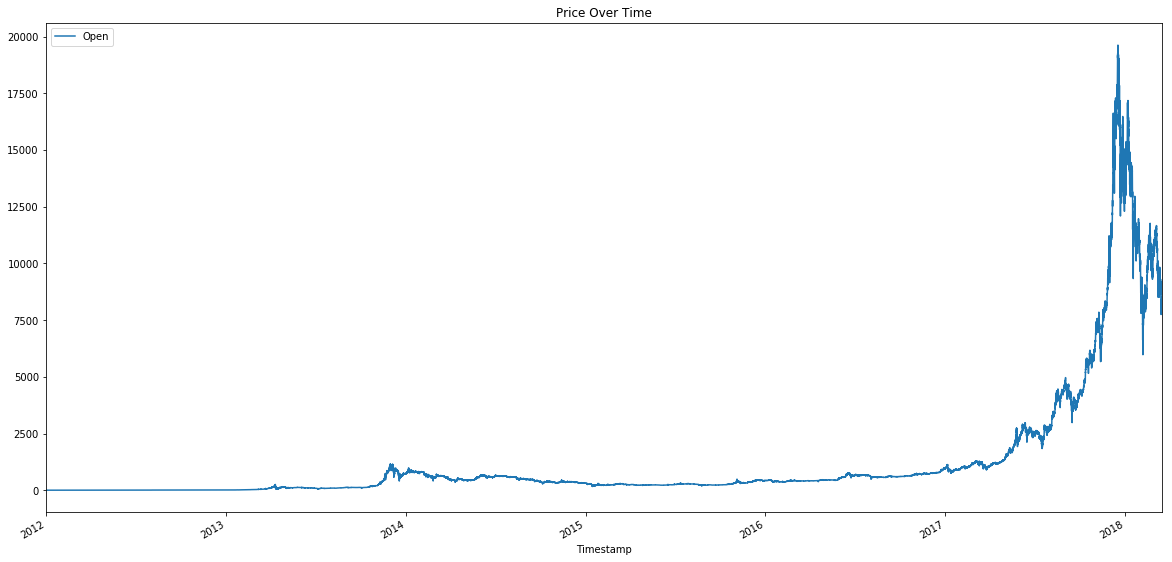

In [203]:
from pylab import rcParams
rcParams['figure.figsize'] =20, 10

df_raw.plot(title = 'Price Over Time',y='Open',x='Timestamp')
plt.show()

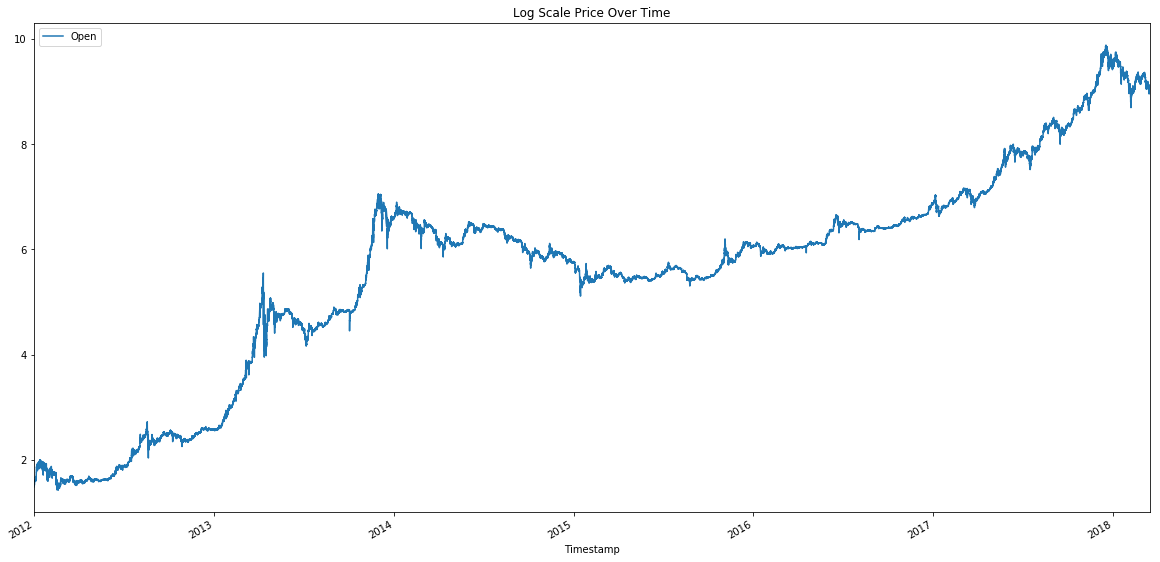

In [204]:
df_temp = df_raw
df_temp['Open']= df_temp['Open'].apply(lambda x:np.log(x)) 
df_temp.plot(title = 'Log Scale Price Over Time',y='Open',x='Timestamp')
plt.show()

### Feature Engineering

In [9]:
def add_prices_n_periods_ago(data, periods, step=DAY_WINDOW):
    return data['Smoothed_Price'].copy().shift(step * periods)

def dummy_increased_since(data, periods, step=DAY_WINDOW):
    return 1 * (data['Smoothed_Price'] > data['Smoothed_Price'].shift(int(step * periods)))

def mean_square_loss(predicted_labels, true_labels):
    assert len(predicted_labels) == len(true_labels)
    return np.mean((predicted_labels - true_labels)**2)

def accuracy(x,y):
    return np.mean(x==y)

In [10]:
def RSI(df, gain_column='Close', period=14):
    data = pd.DataFrame(df[gain_column].copy())
    
    #Compute differences
    data['delta'] = data[gain_column] - data.shift(1)[gain_column]
    
    #Compute gains and losses
    data['gain'] = data[data['delta'] >= 0]['delta']
    data['loss'] = data[data['delta'] <= 0]['delta']
    data['loss'] = -data['loss']
    data['gain'].fillna(0.0, inplace = True)
    data['loss'].fillna(0.0, inplace = True)
    
    #Compute average of gains and losses
    data['avg_gain'] = data['gain'].rolling(period).mean()
    data['avg_loss'] = data['loss'].rolling(period).mean()
    
    #Compute relative strength
    data['RS'] = data['avg_gain'] / data['avg_loss']
    
    return 100 - 100.0/(1.0 + data.RS)
    
def EMA(data, s):    
    return data.ewm(span=s, adjust=False).mean()

def MACD(df, price_column='Close', period1=12, period2=26, smooth_factor=9):
    
    data = df.copy()
    
    data['EMA_'+str(period1)] = EMA(data[price_column], period1)
    data['EMA_'+str(period2)] = EMA(data[price_column], period2)
    
    data['MACD_Line'] = data['EMA_'+str(period1)] - data['EMA_'+str(period2)]
    
    data['Signal_Line'] = EMA(data['MACD_Line'], smooth_factor)
    
    data['MACD_Histogram'] = data['MACD_Line'] - data['Signal_Line']
    
    return data
    
def BB(dataframe, price_column='Close', period = 20):
    df = dataframe.copy()
    
    #Compute middle Band
    df['MA'] = df[price_column].rolling(period).mean()
    
    # Compute std
    df['std'] = df[price_column].rolling(period).std()

    #Compute Upper Band
    df['Upper'] = df['MA'] + 2*df['std']
    
    #Compute Lower Band
    df['Lower'] = df['MA'] - 2*df['std']
    return df

def ATR(df, period=14):
    data = df.copy()
    
    data['v1'] = data.High - data.Low
    data['v2'] = (data.High - data.shift(1).Close).apply(abs)
    data['v3'] = (data.Low - data.shift(1).Close).apply(abs)
    data['True_Range'] = data[['v1','v2','v3']].max(axis=1)
    
    
    return EMA(data.True_Range, period)


def DM(df, period_adx=14):
    data = df.copy()
    data['UpMove'] = data.High - data.shift(1).High
    data['DownMove'] = data.shift(1).Low - data.Low
    
    #Compute directional movement
    data['pDM'] = 0
    data['mDM'] = 0
    data.loc[(data['UpMove'] > data['DownMove']) & (data['UpMove'] > 0), 'pDM'] = data.loc[(data['UpMove'] > data['DownMove']) & (data['UpMove'] > 0), 'UpMove']
    data.loc[(data['UpMove'] < data['DownMove']) & (data['DownMove'] > 0), 'mDM'] = data.loc[(data['UpMove'] < data['DownMove']) & (data['DownMove'] > 0), 'DownMove']

    data['pDI'] = 100.0 * EMA(data['pDM'], period_adx) / data['ATR']
    data['mDI'] = 100.0 * EMA(data['mDM'], period_adx) / data['ATR']
    
    data['ADX'] = EMA(100.0 * ((data['pDI'] - data['mDI']).apply(abs) / (data['pDI'] + data['mDI'])), period_adx)
    
    return data

In [11]:
SMOOTHING_PERIOD = int(0.5 * 2 * 24) # 12h

df_processed = df_raw.copy()
df_processed['Smoothed_Price'] = (0.5 * (df_processed.Close + df_processed.Open)).rolling(SMOOTHING_PERIOD).mean()
df_processed['Inc_1_hour'] = dummy_increased_since(df_processed, 2, 1)
df_processed['Inc_30_min'] = dummy_increased_since(df_processed, 1, 1)
df_processed = df_processed.reset_index(drop=True)
df_processed = MACD(df_processed)
df_processed = BB(df_processed)
df_processed['RSI'] = RSI(df_processed, gain_column='Close')
df_processed['ATR'] = ATR(df_processed)
df_processed = DM(df_processed)
df_processed = df_processed.dropna(how='any')
display(df_processed.head(1))

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Smoothed_Price,Inc_1_hour,...,Lower,RSI,ATR,UpMove,DownMove,pDM,mDM,pDI,mDI,ADX
23,2011-12-31 19:00:00,4.58,4.58,4.58,4.58,270.0,1236.6,4.58,4.433333,0,...,4.269356,100.0,0.012487,0.0,0.0,0.0,0.0,100.0,0.0,100.0


In [13]:
def split_dataset(data, fraction):
    l = len(data)
    
    train = data[0 : int(l * fraction)]
    test = data[ int(l*fraction) :]
    
    return train, test

df = df_processed.copy()

timestamps = df.Timestamp
df = df.drop('Timestamp',1)
df = (df-df.mean())/df.std()
df['Timestamp'] = timestamps
print("Standardized input data")
display(df.describe())

train, test = split_dataset(df, 0.9)

display(train.head())
display(test.head())

Standardized input data


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Smoothed_Price,Inc_1_hour,Inc_30_min,...,Lower,RSI,ATR,UpMove,DownMove,pDM,mDM,pDI,mDI,ADX
count,1.072030e+05,1.072030e+05,1.072030e+05,1.072030e+05,1.072030e+05,1.072030e+05,1.072030e+05,1.072030e+05,1.072030e+05,1.072030e+05,...,1.072030e+05,1.072030e+05,1.072030e+05,1.072030e+05,1.072030e+05,1.072030e+05,1.072030e+05,1.072030e+05,1.072030e+05,1.072030e+05
mean,3.630916e-15,1.192760e-15,-5.210321e-15,4.399786e-15,4.504447e-15,-3.173629e-16,-8.422575e-15,1.470632e-15,-2.058715e-14,-1.922762e-14,...,6.637390e-15,2.911777e-14,3.885059e-15,-2.694494e-16,-9.438289e-17,1.965431e-13,-7.156366e-14,-1.141068e-14,1.396883e-14,6.237752e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.521575e-01,-4.515350e-01,-4.538284e-01,-4.521721e-01,-5.626127e-01,-3.002681e-01,-4.521901e-01,-4.520598e-01,-1.088821e+00,-1.086246e+00,...,-4.552361e-01,-3.074474e+00,-3.247134e-01,-2.737934e+01,-3.133362e+01,-1.555905e-01,-1.453205e-01,-1.420603e+00,-1.588019e+00,-2.036392e+00
25%,-4.098800e-01,-4.093872e-01,-4.104578e-01,-4.098923e-01,-4.278037e-01,-2.902078e-01,-4.099042e-01,-4.098856e-01,-1.088821e+00,-1.086246e+00,...,-4.123630e-01,-6.019758e-01,-3.087220e-01,-1.762184e-02,-1.849371e-02,-1.555905e-01,-1.453205e-01,-6.684106e-01,-6.691880e-01,-7.458058e-01
50%,-3.094075e-01,-3.092185e-01,-3.098318e-01,-3.094476e-01,-2.711130e-01,-2.620192e-01,-3.095200e-01,-3.092953e-01,9.184163e-01,9.205930e-01,...,-3.103100e-01,-1.948871e-02,-2.811332e-01,-2.869452e-03,2.446679e-03,-1.555905e-01,-1.453205e-01,-2.203780e-01,-1.962153e-01,-1.981230e-01
75%,-1.955992e-01,-1.954393e-01,-1.956463e-01,-1.955116e-01,5.230628e-02,-1.613267e-01,-1.954284e-01,-1.956148e-01,9.184163e-01,9.205930e-01,...,-1.943310e-01,6.034525e-01,-2.072287e-01,8.644605e-03,1.199303e-02,-1.440152e-01,-1.358360e-01,3.940731e-01,4.198900e-01,5.615697e-01
max,6.579328e+00,6.542935e+00,6.594953e+00,6.569700e+00,7.881166e+01,3.742007e+01,6.579344e+00,6.483980e+00,9.184163e-01,9.205930e-01,...,6.654045e+00,2.887724e+00,1.650816e+01,3.129162e+01,3.717626e+01,4.361625e+01,4.963412e+01,5.761035e+00,5.589627e+00,4.182924e+00


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Smoothed_Price,Inc_1_hour,Inc_30_min,...,RSI,ATR,UpMove,DownMove,pDM,mDM,pDI,mDI,ADX,Timestamp
23,-0.452,-0.451379,-0.452715,-0.452014,-0.110524,-0.299346,-0.452032,-0.451999,-1.088821,-1.086246,...,2.887724,-0.324465,-0.002869,0.002447,-0.15559,-0.145321,5.761035,-1.588019,4.182924,2011-12-31 19:00:00
24,-0.452,-0.451379,-0.452715,-0.452014,-0.110524,-0.299346,-0.452032,-0.451996,-1.088821,0.920593,...,2.887724,-0.324499,-0.002869,0.002447,-0.15559,-0.145321,5.761035,-1.588019,4.182924,2011-12-31 19:30:00
25,-0.452,-0.451379,-0.452715,-0.452014,-0.110524,-0.299346,-0.452032,-0.451993,0.918416,0.920593,...,2.887724,-0.324528,-0.002869,0.002447,-0.15559,-0.145321,5.761035,-1.588019,4.182924,2011-12-31 20:00:00
26,-0.452,-0.451379,-0.452715,-0.452014,-0.110524,-0.299346,-0.452032,-0.451990,0.918416,0.920593,...,2.887724,-0.324553,-0.002869,0.002447,-0.15559,-0.145321,5.761035,-1.588019,4.182924,2011-12-31 20:30:00
27,-0.452,-0.451379,-0.452715,-0.452014,-0.110524,-0.299346,-0.452032,-0.451988,0.918416,0.920593,...,2.887724,-0.324575,-0.002869,0.002447,-0.15559,-0.145321,5.761035,-1.588019,4.182924,2011-12-31 21:00:00


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Smoothed_Price,Inc_1_hour,Inc_30_min,...,RSI,ATR,UpMove,DownMove,pDM,mDM,pDI,mDI,ADX,Timestamp
97899,0.677039,0.685912,0.683871,0.682909,0.643333,1.408178,0.685833,0.619101,0.918416,0.920593,...,1.819648,0.732582,1.237410,-1.184381,1.579199,-0.145321,1.525467,-1.281077,2.478553,2017-08-05 08:30:00
97900,0.680848,0.696026,0.689617,0.703761,0.732584,1.546785,0.692341,0.624542,0.918416,0.920593,...,1.872918,0.764842,1.020083,-0.487189,1.275220,-0.145321,1.563491,-1.329879,2.566159,2017-08-05 09:00:00
97901,0.703506,0.696026,0.693649,0.689065,0.350448,1.004759,0.695165,0.630098,0.918416,0.920593,...,1.354598,0.762640,-0.002869,-0.341222,-0.155590,-0.145321,1.170844,-1.363845,2.642085,2017-08-05 09:30:00
97902,0.686610,0.681398,0.688200,0.685847,-0.140092,0.296993,0.684168,0.635179,0.918416,0.920593,...,0.583162,0.690628,-1.482426,0.466831,-0.155590,0.476536,0.984605,-1.091799,2.547576,2017-08-05 10:00:00
97903,0.683883,0.687132,0.692685,0.690506,0.018055,0.525635,0.690207,0.640180,0.918416,0.920593,...,0.622702,0.637974,0.577151,-0.379715,0.655689,-0.145321,1.102915,-1.134440,2.498410,2017-08-05 10:30:00


# LSTM

In [22]:
to_drop = ['Timestamp', 'Open', 'Close', 'High', 'Low', 'Volume_(BTC)', 'Weighted_Price', 'Volume_(Currency)']
train_lstm = train.copy().drop(to_drop,1)
test_lstm = test.copy().drop(to_drop,1)

train_lstm.head(1)

,Smoothed_Price,Inc_1_hour,Inc_30_min,EMA_12,EMA_26,MACD_Line,Signal_Line,MACD_Histogram,MA,std,...,Lower,RSI,ATR,UpMove,DownMove,pDM,mDM,pDI,mDI,ADX
23,-0.451999,-1.088821,-1.086246,-0.452042,-0.452043,-0.014695,-0.016162,0.001787,-0.452015,-0.302003,...,-0.455136,2.887724,-0.324465,-0.002869,0.002447,-0.15559,-0.145321,5.761035,-1.588019,4.182924


### Create the new dataset

We first create the new dataset by concatenating n datapoints into a single one. The y will be calculated by taking the price of the last datapoint and comparing it to the next one. 

In [92]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1,look_forward = 48):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - look_forward + 1):
        a = dataset[i:(i+look_back), 1:]
        dataX.append(a)
        dataY.append((dataset[i + look_back -1, 0] > dataset[i + look_back -1 + look_forward, 0])*1)
    return np.array(dataX), np.array(dataY)

In [93]:
train_test = np.asarray([[1,2,0],[20,3,1000],[4,5,-10],[10,5,10],[100,7,1],[2,3,20],[10,3,1000]])
trainX_test, trainY_test = create_dataset(train_test, look_back = 3,look_forward= 2)

print(trainX_test)
print(trainY_test)

[[[   2    0]
  [   3 1000]
  [   5  -10]]

 [[   3 1000]
  [   5  -10]
  [   5   10]]

 [[   5  -10]
  [   5   10]
  [   7    1]]]
[0 1 1]


In [94]:
import random

def downsample(x,y):
    print("Ratio: " + str(y.sum()/y.shape[0]))
    numberOf1 = y.sum()
    numberOf0 = y.shape - y.sum()
    minNumber = min(numberOf0,numberOf1)

    indexes = np.asarray(random.sample(list(np.where(y == 0)[0]), minNumber) + 
                         random.sample(list(np.where(y == 1)[0]), minNumber))
    indexes.sort()
    y_downsample = y.take(indexes)
    x_downsample = x.take(indexes,0)
        
    print("Downsample Ratio: " + str(y_downsample.sum()/y_downsample.shape[0]))

    return x_downsample,y_downsample

In [95]:
batch_size = 800

In [96]:
def create_x_y(look_back = 16,batch_size = batch_size):
    trainX, trainY = create_dataset(train_lstm.values, look_back)
    testX, testY = create_dataset(test_lstm.values, look_back)
    trainX_downsample, trainY_downsample = downsample(trainX,trainY)
    testX_downsample, testY_downsample = downsample(testX,testY)
    
    trainX_downsample = trainX_downsample[:batch_size*105,:,:]
    trainY_downsample= trainY_downsample[:batch_size*105]
    testX_downsample = testX_downsample[:batch_size*11,:,:]
    testY_downsample= testY_downsample[:batch_size*11]

    print(trainX_downsample.shape)
    print(testX_downsample.shape)
    
    print(trainY_downsample.shape)
    
    return trainX_downsample, trainY_downsample,testX_downsample, testY_downsample

## No look back

In [97]:
look_back = 1
trainX_downsample, trainY_downsample,testX_downsample, testY_downsample = create_x_y(look_back)

Ratio: 0.438030155339
Downsample Ratio: 0.5
Ratio: 0.443455448328
Downsample Ratio: 0.5
(84000, 1, 20)
(8800, 1, 20)
(84000,)


In [99]:
# create and fit the LSTM network
model_0min = Sequential()
model_0min.add(LSTM(100, batch_input_shape=(batch_size,look_back,trainX_downsample.shape[2]), return_sequences=True,kernel_regularizer = L1L2(l2=0.01)))
model_0min.add(LSTM(100, return_sequences=True, stateful=True,kernel_regularizer = L1L2(l2=0.01)))
model_0min.add(LSTM(100, stateful=True,kernel_regularizer = L1L2(l2=0.01)))
model_0min.add(Dense(1, activation='sigmoid'))
model_0min.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history_0min = model_0min.fit(trainX_downsample, trainY_downsample, epochs=30
                    ,validation_data = (testX_downsample,testY_downsample), batch_size= batch_size, verbose=1)

Train on 84000 samples, validate on 8800 samples
Epoch 1/30
84000/84000 [==============================] - 10s 115us/step - loss: 1.7552 - acc: 0.4987 - val_loss: 0.7778 - val_acc: 0.5101
Epoch 2/30
84000/84000 [==============================] - 6s 76us/step - loss: 0.7109 - acc: 0.4971 - val_loss: 0.6936 - val_acc: 0.4899
Epoch 3/30
84000/84000 [==============================] - 7s 85us/step - loss: 0.6932 - acc: 0.5011 - val_loss: 0.6931 - val_acc: 0.5101
Epoch 4/30
84000/84000 [==============================] - 7s 83us/step - loss: 0.6932 - acc: 0.4977 - val_loss: 0.6931 - val_acc: 0.5101
Epoch 5/30
84000/84000 [==============================] - 7s 82us/step - loss: 0.6932 - acc: 0.4976 - val_loss: 0.6932 - val_acc: 0.4899
Epoch 6/30
84000/84000 [==============================] - 7s 83us/step - loss: 0.6931 - acc: 0.5006 - val_loss: 0.6933 - val_acc: 0.4899
Epoch 7/30
84000/84000 [==============================] - 7s 81us/step - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6931 - val_ac

## 4 hours look back

In [190]:
look_back = 8
trainX_downsample, trainY_downsample,testX_downsample, testY_downsample = create_x_y(look_back)

Ratio: 0.438061953602
Downsample Ratio: 0.5
Ratio: 0.443746484155
Downsample Ratio: 0.5
(84000, 8, 20)
(8800, 8, 20)
(84000,)


In [196]:
# create and fit the LSTM network
model_4hours = Sequential()
model_4hours.add(LSTM(100, batch_input_shape=(batch_size,look_back,trainX_downsample.shape[2]), return_sequences=True,kernel_regularizer = L1L2(l2=0.005)))
model_4hours.add(LSTM(100, return_sequences=True, stateful=True,kernel_regularizer = L1L2(l2=0.005)))
model_4hours.add(LSTM(100, stateful=True,kernel_regularizer = L1L2(l2=0.005)))
model_4hours.add(Dense(1, activation='sigmoid'))
model_4hours.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history_4hours = model_4hours.fit(trainX_downsample, trainY_downsample, epochs=30
                    ,validation_data = (testX_downsample,testY_downsample), batch_size= batch_size, verbose=1)

Train on 84000 samples, validate on 8800 samples
Epoch 1/30
84000/84000 [==============================] - 85s 1ms/step - loss: 1.2000 - acc: 0.6223 - val_loss: 0.6987 - val_acc: 0.6351
Epoch 2/30
84000/84000 [==============================] - 79s 942us/step - loss: 0.6585 - acc: 0.6367 - val_loss: 0.6611 - val_acc: 0.6275
Epoch 3/30
84000/84000 [==============================] - 80s 952us/step - loss: 0.6372 - acc: 0.6456 - val_loss: 0.6561 - val_acc: 0.6394
Epoch 4/30
84000/84000 [==============================] - 80s 950us/step - loss: 0.6299 - acc: 0.6511 - val_loss: 0.6477 - val_acc: 0.6473
Epoch 5/30
84000/84000 [==============================] - 79s 944us/step - loss: 0.6262 - acc: 0.6549 - val_loss: 0.6344 - val_acc: 0.6428
Epoch 6/30
84000/84000 [==============================] - 82s 981us/step - loss: 0.6264 - acc: 0.6538 - val_loss: 0.6250 - val_acc: 0.6528
Epoch 7/30
84000/84000 [==============================] - 81s 970us/step - loss: 0.6235 - acc: 0.6555 - val_loss: 0.637

## 8 hours look back

In [102]:
look_back = 16
trainX_downsample, trainY_downsample,testX_downsample, testY_downsample = create_x_y(look_back)

Ratio: 0.438098300128
Downsample Ratio: 0.5
Ratio: 0.444079564646
Downsample Ratio: 0.5
(84000, 16, 20)
(8800, 16, 20)
(84000,)


In [103]:
# create and fit the LSTM network
model_8hours = Sequential()
model_8hours.add(LSTM(100, batch_input_shape=(batch_size,look_back,trainX_downsample.shape[2]), return_sequences=True,kernel_regularizer = L1L2(l2=0.01)))
model_8hours.add(LSTM(100, return_sequences=True, stateful=True,kernel_regularizer = L1L2(l2=0.01)))
model_8hours.add(LSTM(100, stateful=True,kernel_regularizer = L1L2(l2=0.01)))
model_8hours.add(Dense(1, activation='sigmoid'))
model_8hours.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history_8hours = model_8hours.fit(trainX_downsample, trainY_downsample, epochs=30
                    ,validation_data = (testX_downsample,testY_downsample), batch_size= batch_size, verbose=1)

Train on 84000 samples, validate on 8800 samples
Epoch 1/30
84000/84000 [==============================] - 90s 1ms/step - loss: 1.7456 - acc: 0.6156 - val_loss: 0.7467 - val_acc: 0.6255
Epoch 2/30
84000/84000 [==============================] - 87s 1ms/step - loss: 0.6726 - acc: 0.6327 - val_loss: 0.6482 - val_acc: 0.6344
Epoch 3/30
84000/84000 [==============================] - 87s 1ms/step - loss: 0.6423 - acc: 0.6395 - val_loss: 0.6545 - val_acc: 0.6359
Epoch 4/30
84000/84000 [==============================] - 88s 1ms/step - loss: 0.6365 - acc: 0.6463 - val_loss: 0.6487 - val_acc: 0.6431
Epoch 5/30
84000/84000 [==============================] - 87s 1ms/step - loss: 0.6314 - acc: 0.6504 - val_loss: 0.6479 - val_acc: 0.6377
Epoch 6/30
84000/84000 [==============================] - 87s 1ms/step - loss: 0.6290 - acc: 0.6517 - val_loss: 0.6502 - val_acc: 0.6400
Epoch 7/30
84000/84000 [==============================] - 87s 1ms/step - loss: 0.6281 - acc: 0.6533 - val_loss: 0.6519 - val_acc:

## 1 day look back: different regularization

In [206]:
look_back = 48
trainX_downsample, trainY_downsample,testX_downsample, testY_downsample = create_x_y(look_back)

Ratio: 0.438243746563
Downsample Ratio: 0.5
Ratio: 0.444381705251
Downsample Ratio: 0.5
(84000, 48, 20)
(8800, 48, 20)
(84000,)


In [105]:
# create and fit the LSTM network
model1 = Sequential()
model1.add(LSTM(100, batch_input_shape=(batch_size,look_back,trainX_downsample.shape[2]), return_sequences=True,kernel_regularizer = L1L2(l2=0.01)))
model1.add(LSTM(100, return_sequences=True, stateful=True,kernel_regularizer = L1L2(l2=0.01)))
model1.add(LSTM(100, stateful=True,kernel_regularizer = L1L2(l2=0.01)))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history1 = model1.fit(trainX_downsample, trainY_downsample, epochs=30
                    ,validation_data = (testX_downsample,testY_downsample), batch_size= batch_size, verbose=1)

Train on 84000 samples, validate on 8800 samples
Epoch 1/30
84000/84000 [==============================] - 316s 4ms/step - loss: 1.7313 - acc: 0.6171 - val_loss: 0.7388 - val_acc: 0.6328
Epoch 2/30
84000/84000 [==============================] - 350s 4ms/step - loss: 0.6726 - acc: 0.6309 - val_loss: 0.6720 - val_acc: 0.6127
Epoch 3/30
84000/84000 [==============================] - 349s 4ms/step - loss: 0.6443 - acc: 0.6404 - val_loss: 0.6417 - val_acc: 0.6524
Epoch 4/30
84000/84000 [==============================] - 346s 4ms/step - loss: 0.6378 - acc: 0.6460 - val_loss: 0.6529 - val_acc: 0.6472
Epoch 5/30
84000/84000 [==============================] - 350s 4ms/step - loss: 0.6305 - acc: 0.6515 - val_loss: 0.6507 - val_acc: 0.6366
Epoch 6/30
84000/84000 [==============================] - 349s 4ms/step - loss: 0.6274 - acc: 0.6526 - val_loss: 0.6447 - val_acc: 0.6457
Epoch 7/30
84000/84000 [==============================] - 349s 4ms/step - loss: 0.6227 - acc: 0.6577 - val_loss: 0.6949 - v

In [106]:
model2 = Sequential()
model2.add(LSTM(100, batch_input_shape=(batch_size,look_back,trainX_downsample.shape[2]), return_sequences=True))
model2.add(Dropout(0.6))
model2.add(LSTM(100, return_sequences=True, stateful=True))
model2.add(Dropout(0.6))
model2.add(LSTM(100, stateful=True))
model2.add(Dropout(0.6))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history2 = model2.fit(trainX_downsample, trainY_downsample, epochs= 30
                    ,validation_data = (testX_downsample,testY_downsample), batch_size= batch_size, verbose=1)

Train on 84000 samples, validate on 8800 samples
Epoch 1/30
84000/84000 [==============================] - 413s 5ms/step - loss: 0.6405 - acc: 0.6314 - val_loss: 0.6476 - val_acc: 0.6312
Epoch 2/30
84000/84000 [==============================] - 411s 5ms/step - loss: 0.6224 - acc: 0.6494 - val_loss: 0.6234 - val_acc: 0.6390
Epoch 3/30
84000/84000 [==============================] - 411s 5ms/step - loss: 0.6149 - acc: 0.6578 - val_loss: 0.6188 - val_acc: 0.6525
Epoch 4/30
84000/84000 [==============================] - 409s 5ms/step - loss: 0.6019 - acc: 0.6685 - val_loss: 0.7040 - val_acc: 0.6303
Epoch 5/30
84000/84000 [==============================] - 411s 5ms/step - loss: 0.5832 - acc: 0.6865 - val_loss: 0.8889 - val_acc: 0.5447
Epoch 6/30
84000/84000 [==============================] - 415s 5ms/step - loss: 0.5551 - acc: 0.7094 - val_loss: 1.1349 - val_acc: 0.5569
Epoch 7/30
84000/84000 [==============================] - 412s 5ms/step - loss: 0.5206 - acc: 0.7342 - val_loss: 1.1530 - v

In [122]:
# create and fit the LSTM network
model3 = Sequential()
model3.add(LSTM(100, batch_input_shape=(batch_size,look_back,trainX_downsample.shape[2]), return_sequences=True))
model3.add(Dropout(0.8))
model3.add(LSTM(100, return_sequences=True, stateful=True))
model3.add(Dropout(0.8))
model3.add(LSTM(100, stateful=True))
model3.add(Dropout(0.8))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history3 = model3.fit(trainX_downsample, trainY_downsample, epochs= 30
                    ,validation_data = (testX_downsample,testY_downsample), batch_size= batch_size, verbose=1)

Train on 84000 samples, validate on 8800 samples
Epoch 1/30
84000/84000 [==============================] - 586s 7ms/step - loss: 0.6484 - acc: 0.6257 - val_loss: 0.6339 - val_acc: 0.6393
Epoch 2/30
84000/84000 [==============================] - 527s 6ms/step - loss: 0.6330 - acc: 0.6419 - val_loss: 0.6276 - val_acc: 0.6425
Epoch 3/30
84000/84000 [==============================] - 435s 5ms/step - loss: 0.6269 - acc: 0.6482 - val_loss: 0.6254 - val_acc: 0.6440
Epoch 4/30
84000/84000 [==============================] - 436s 5ms/step - loss: 0.6200 - acc: 0.6545 - val_loss: 0.6311 - val_acc: 0.6383
Epoch 5/30
84000/84000 [==============================] - 439s 5ms/step - loss: 0.6102 - acc: 0.6679 - val_loss: 0.6361 - val_acc: 0.6595
Epoch 6/30
84000/84000 [==============================] - 434s 5ms/step - loss: 0.5946 - acc: 0.6811 - val_loss: 0.7919 - val_acc: 0.6033
Epoch 7/30
84000/84000 [==============================] - 434s 5ms/step - loss: 0.5750 - acc: 0.7002 - val_loss: 0.7031 - v

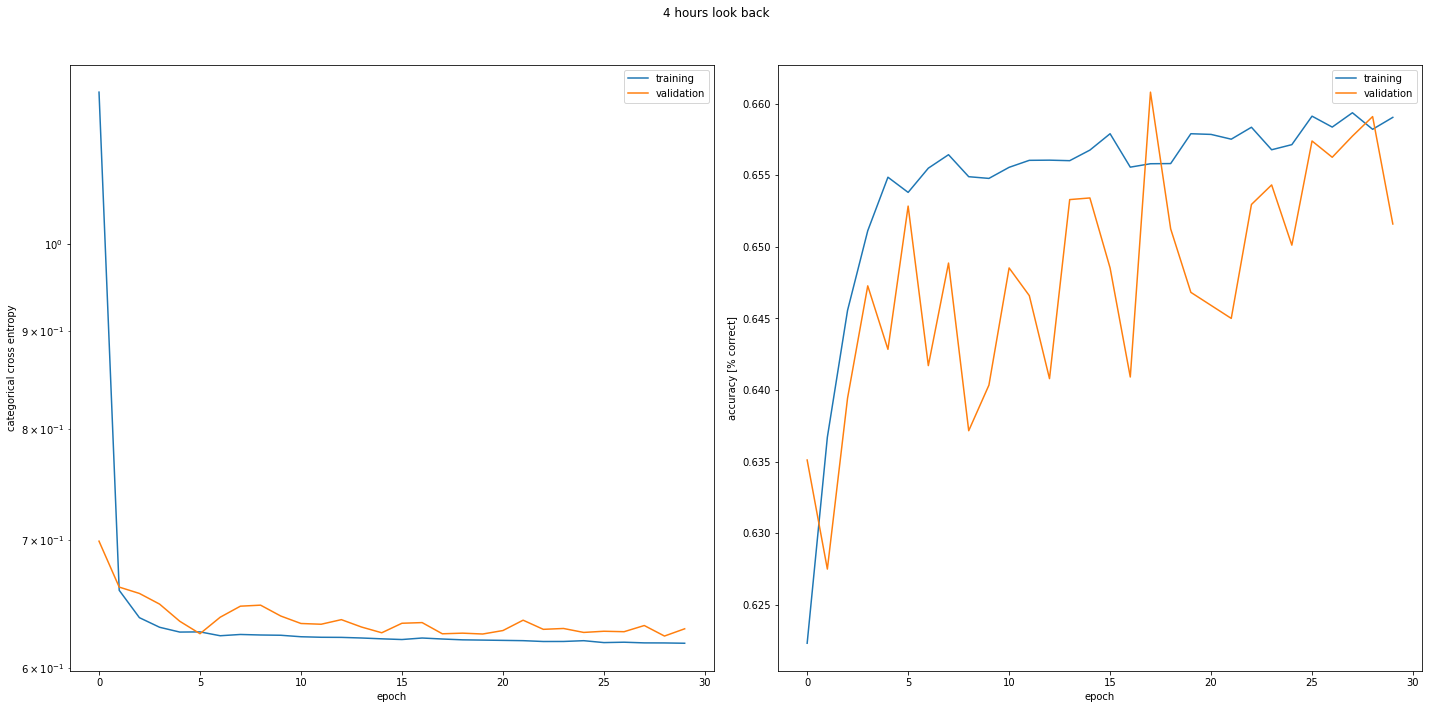

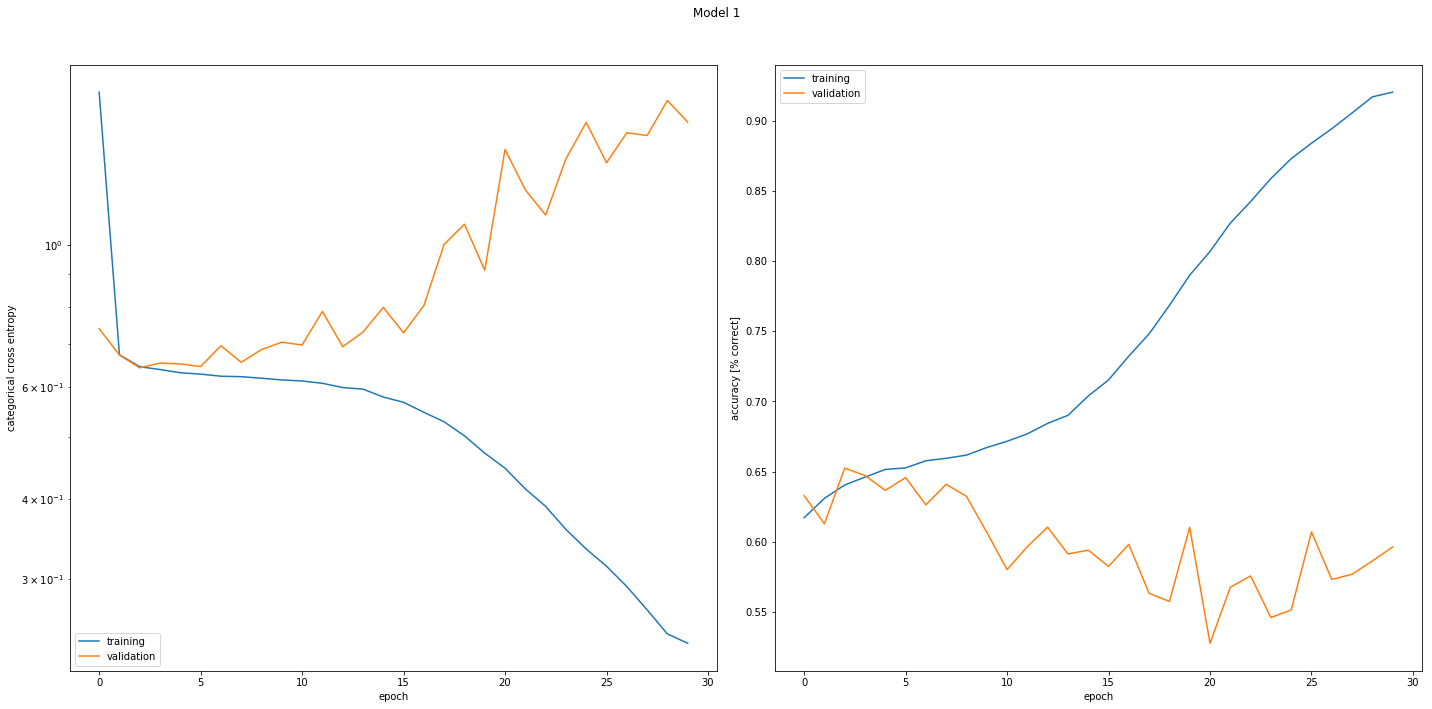

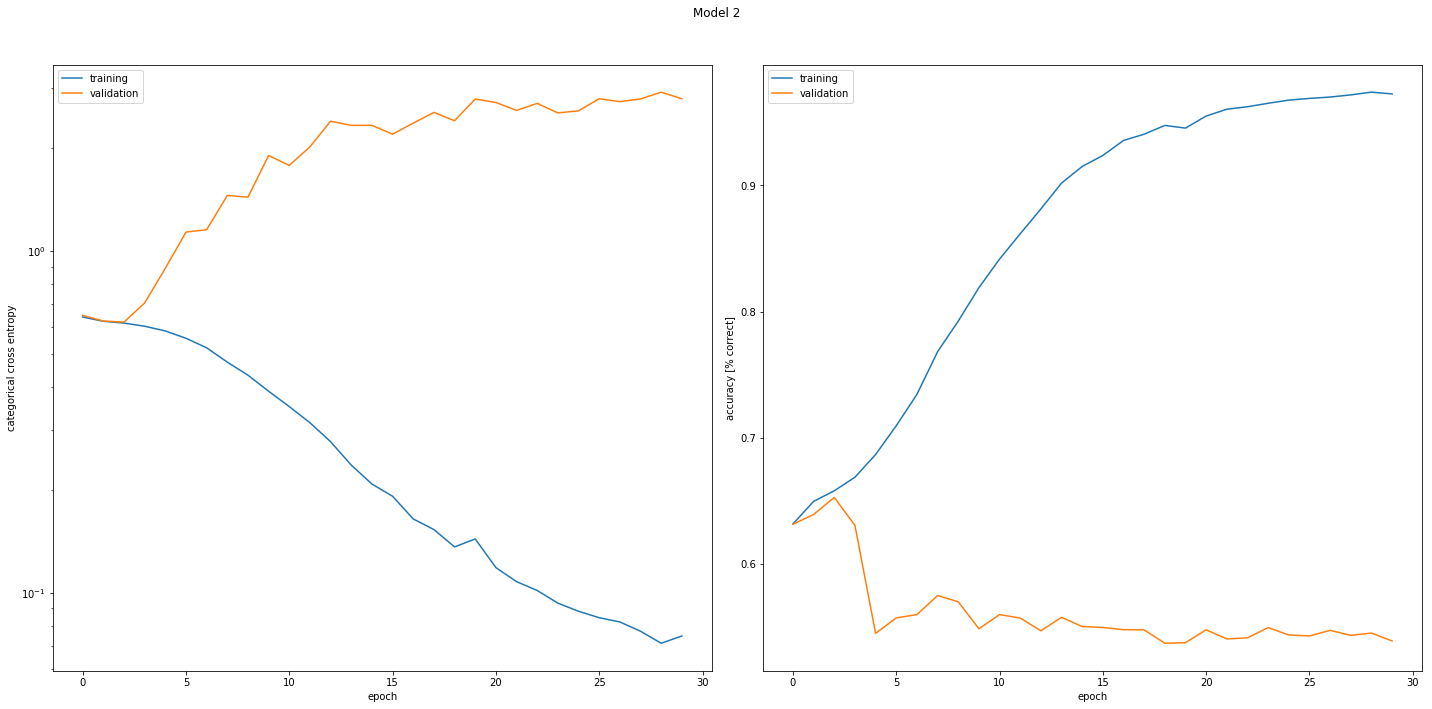

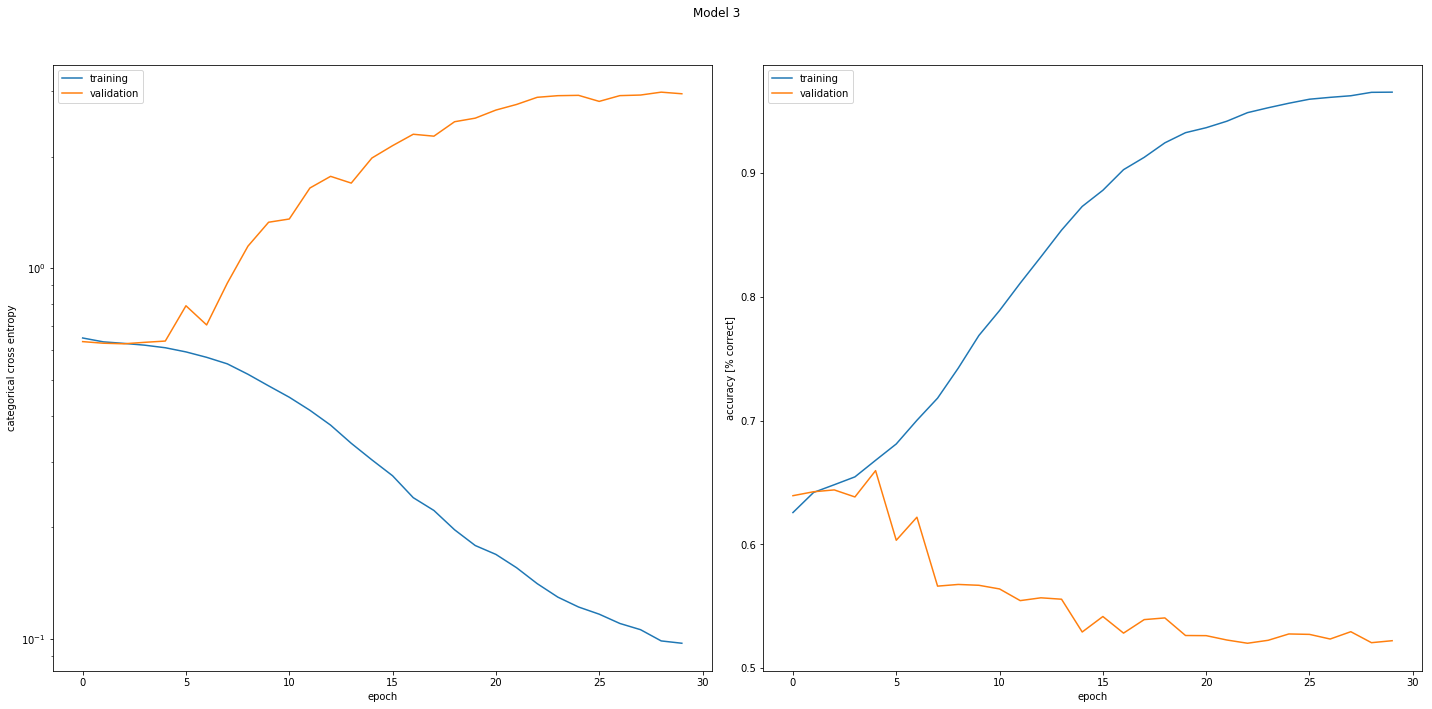

In [208]:
plot_history(history_4hours,"4 hours look back")
plot_history(history1,"Model 1")
plot_history(history2,"Model 2")
plot_history(history3,"Model 3")
plt.show()

In [198]:
def plot_different_look_back(list):
    fig, ax = plt.subplots(1, figsize=(10, 15))
    linewidth = 3
    for elem in list:
        history,name,color = elem
        ax.plot(history.history['acc'], label = "Train accuracy for " +  name,linestyle= ':',color = color, linewidth=linewidth)
        ax.plot(history.history['val_acc'], label = "Validation accuracy for " + name,linestyle= '-',color = color, linewidth=linewidth)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 15})
    plt.show()

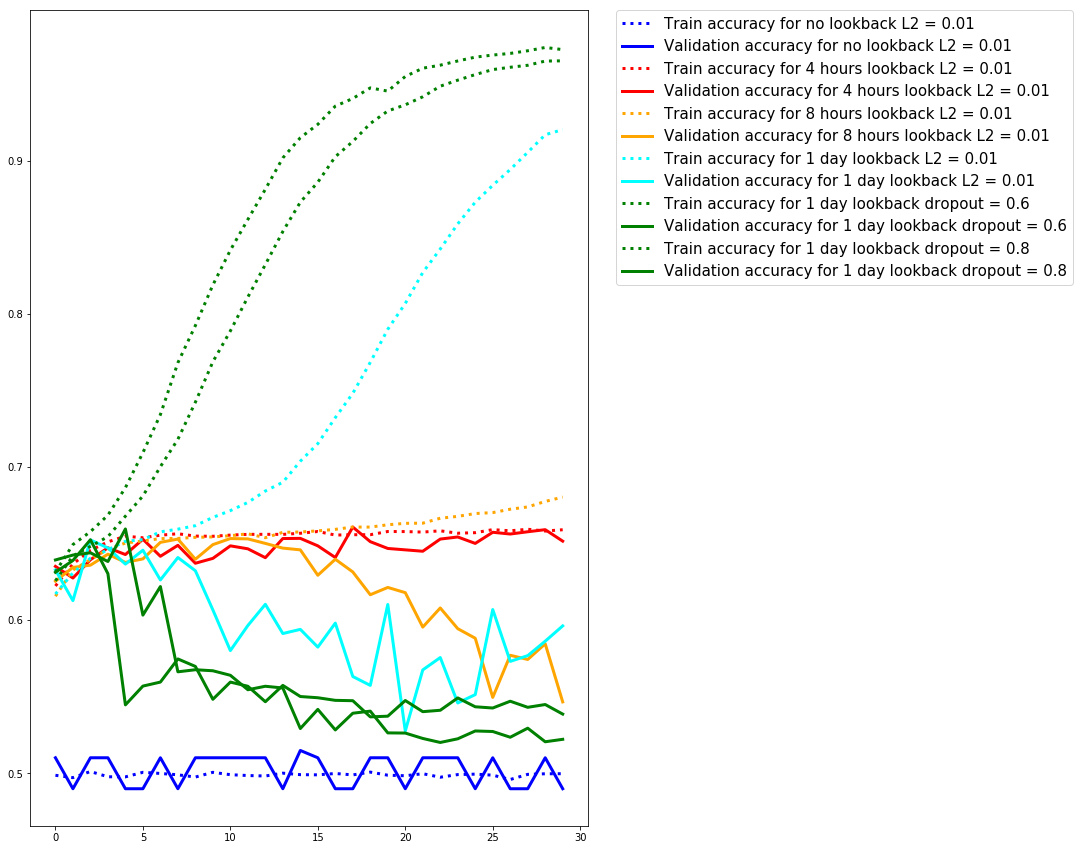

In [199]:
plot_different_look_back([(history_0min,'no lookback L2 = 0.01','b'),
                        (history_4hours,'4 hours lookback L2 = 0.01','red'),
                           (history_8hours,'8 hours lookback L2 = 0.01','orange'),
                           (history1,'1 day lookback L2 = 0.01','cyan'),
                           (history2,'1 day lookback dropout = 0.6','g'),
                          (history3,'1 day lookback dropout = 0.8','g')
                          ])